# Single series vs multi series forecasting

In univariate time series forecasting, a single time series is modeled as a linear or nonlinear combination of its lags. That is, the past values of the series are used to forecast its future. In multi-time series forecasting, two or more time series are modeled together using a single model.

¿Is it better to create a model for each series or a single one for all of them?

## Libraries

In [2]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries import grid_search_forecaster_multiseries

/home/ubuntu/anaconda3/envs/skforecast/lib/python3.8/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


## Data

In [3]:
# Data download
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/' +
       'data/vic_elec.csv')
data = pd.read_csv(url, sep=',')

# Data preparation (aggregation at daily level)
# ==============================================================================
data['Time'] = pd.to_datetime(data['Time'], format='%Y-%m-%dT%H:%M:%SZ')
data = data.set_index('Time')
data = data.asfreq('30min')
data = data.sort_index()
data = data.drop(columns='Date')
data = data.resample(rule='H', closed='left', label ='right')\
       .agg({'Demand': 'sum', 'Temperature': 'mean'})

data.head()

,Demand,Temperature
Time,,
2011-12-31 14:00:00,8646.190700,21.225
2011-12-31 15:00:00,7926.529376,20.625
2011-12-31 16:00:00,7901.826990,20.325
2011-12-31 17:00:00,7255.721350,19.850
2011-12-31 18:00:00,6792.503352,19.025


In [4]:
# Split data into train-test
# ==============================================================================
data = data.loc['2014-06-01 00:00:00': '2014-07-31 23:59:00']
end_train = '2014-07-15 23:59:00'
data_train = data.loc[:end_train, :].copy()
data_test  = data.loc[end_train:, :].copy()

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Train dates : 2014-06-01 00:00:00 --- 2014-07-15 23:00:00  (n=1080)
Test dates  : 2014-07-16 00:00:00 --- 2014-07-31 23:00:00  (n=384)


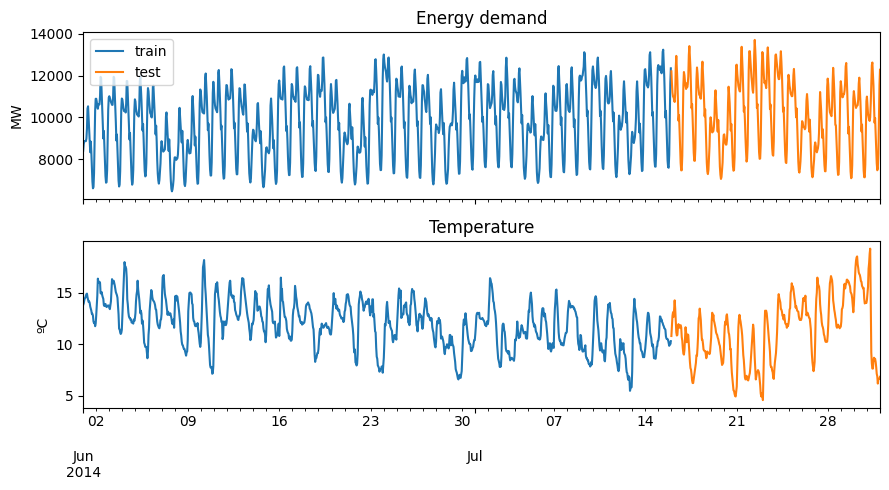

In [5]:
# Plot time series
# ==============================================================================
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(9, 5), sharex=True)

data_train['Demand'].plot(label='train', ax=axes[0])
data_test['Demand'].plot(label='test', ax=axes[0])
axes[0].set_xlabel('')
axes[0].set_ylabel('MW')
axes[0].set_title('Energy demand')
axes[0].legend()

data_train['Temperature'].plot(label='train', ax=axes[1])
data_test['Temperature'].plot(label='test', ax=axes[1])
axes[1].set_xlabel('')
axes[1].set_ylabel('ºC')
axes[1].set_title('Temperature')

fig.tight_layout()
plt.show();

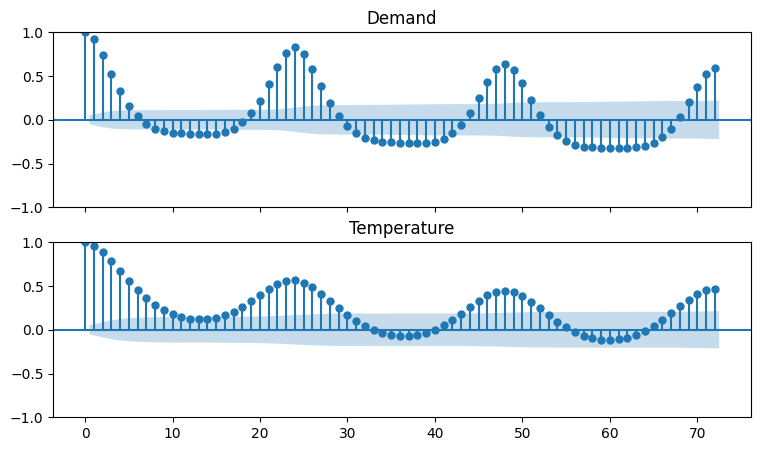

In [6]:
# Autocorrelation plot
# ==============================================================================
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(9, 5), sharex=True)
plot_acf(data['Demand'], ax=axes[0], lags=72)
axes[0].set_title('Demand')
plot_acf(data['Temperature'], ax=axes[1], lags=72)
axes[1].set_title('Temperature')
plt.show()

## Multi series forecaster with linear models

For this first study, the forecasting performance of a multi-series forecaster (non-multivariate) will be compared with that of single forecasters. For all of them, a linear model will be used as regressor.

First, an individual autoregressive forecaster is trained for each series and their forecasting capability is measured with backtesting.

In [21]:
# ForecasterAutoreg with linear models
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor        = LinearRegression(),
                 lags             = 24,
                 transformer_y    = StandardScaler(),
                 transformer_exog = None
             )

metric_demand, predictions_demand = backtesting_forecaster(
                                        forecaster         = forecaster,
                                        y                  = data['Demand'],
                                        initial_train_size = len(data_train),
                                        fixed_train_size   = True,
                                        steps              = 24,
                                        metric             = 'mean_absolute_error',
                                        refit              = True,
                                        verbose            = False
                                )

metric_temperature, predictions_temperature = backtesting_forecaster(
                                                    forecaster         = forecaster,
                                                    y                  = data['Temperature'],
                                                    initial_train_size = len(data_train),
                                                    fixed_train_size   = True,
                                                    steps              = 24,
                                                    metric             = 'mean_absolute_error',
                                                    refit              = True,
                                                    verbose            = False
                                              )


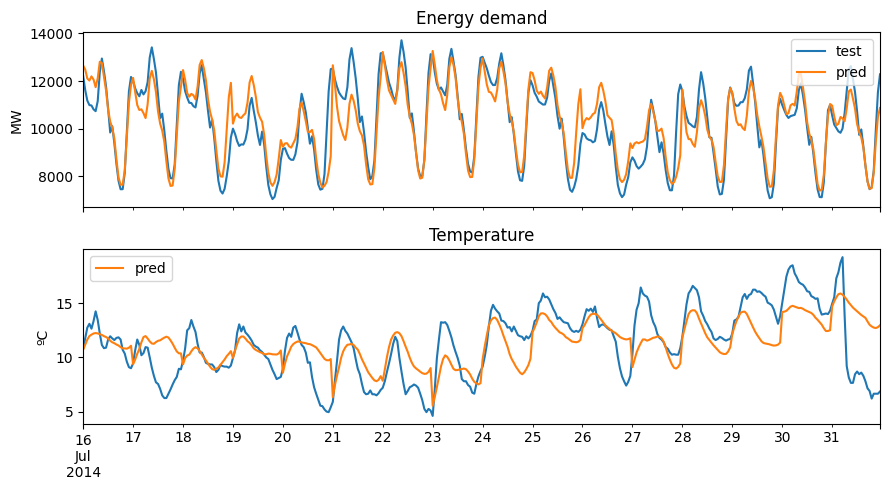

In [22]:
# Plot predictions
# ==============================================================================
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(9, 5), sharex=True)

data_test['Demand'].plot(label='test', ax=axes[0])
predictions_demand.plot(label='pred', ax=axes[0])
axes[0].set_xlabel('')
axes[0].set_ylabel('MW')
axes[0].set_title('Energy demand')
axes[0].legend()

data_test['Temperature'].plot(label='test', ax=axes[1])
predictions_temperature.plot(label='pred', ax=axes[1])
axes[1].set_xlabel('')
axes[1].set_ylabel('ºC')
axes[1].set_title('Temperature')
axes[0].legend()

fig.tight_layout()
plt.show();

In [23]:
# Backtesting metrics
# ==============================================================================
print('Backtesting metrics individual forecasters')
print('===================================================')
print(f"Demand: {metric_demand:.2f}")
print(f"Temperature: {metric_temperature:.2f}")

Backtesting metrics individual forecasters
Demand: 571.22
Temperature: 1.88


Now, a multi-series (non-multivariate) forecaster is trained to model both series at the same time. As for the single forecasters, its performance is measured with backtesting.

In [24]:
# ForecasterAutoregMultiSeries with linear models
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                 regressor          = LinearRegression(),
                 lags               = 24,
                 transformer_series = StandardScaler(),
                 transformer_exog   = None
             )

# Backtesting
# ==============================================================================
metric_demand, predictions_demand = backtesting_forecaster_multiseries(
                                          forecaster         = forecaster,
                                          series             = data[['Demand', 'Temperature']],
                                          level              = 'Demand',
                                          initial_train_size = len(data_train),
                                          fixed_train_size   = True,
                                          steps              = 24,
                                          metric             = 'mean_absolute_error',
                                          refit              = True,
                                          verbose            = False
                                    )

metric_temperature, predictions_temperature = backtesting_forecaster_multiseries(
                                                 forecaster         = forecaster,
                                                 series             = data[['Demand', 'Temperature']],
                                                 level              = 'Temperature',
                                                 initial_train_size = len(data_train),
                                                 fixed_train_size   = True,
                                                 steps              = 24,
                                                 metric             = 'mean_absolute_error',
                                                 refit              = True,
                                                 verbose            = False
                                              )

In [25]:
# Backtesting metrics
# ==============================================================================
print('Backtesting metrics using a multi-series forecaster')
print('===================================================')
print(f"Demand: {metric_demand:.2f}")
print(f"Temperature: {metric_temperature:.2f}")

Backtesting metrics using a multi-series forecaster
Demand: 571.41
Temperature: 1.78


The performance of both approaches is very similar, then, using a multi-series model has the advantage of maintaining onl one model instead of two.

In the previous example, both time series had a similar dynamic: the current value is highly correlated with the lags 1, 2, 3, 24, 48. What would happen if one the series do not share the same internal dynamics?

To better understand the behavior of the multi-series forecaster in this scenario, the variable temperature is replaced with random noise and then, the forecaster is fitted and evaluated.

Train dates : 2014-06-01 00:00:00 --- 2014-07-15 23:00:00  (n=1080)
Test dates  : 2014-07-16 00:00:00 --- 2014-07-31 23:00:00  (n=384)


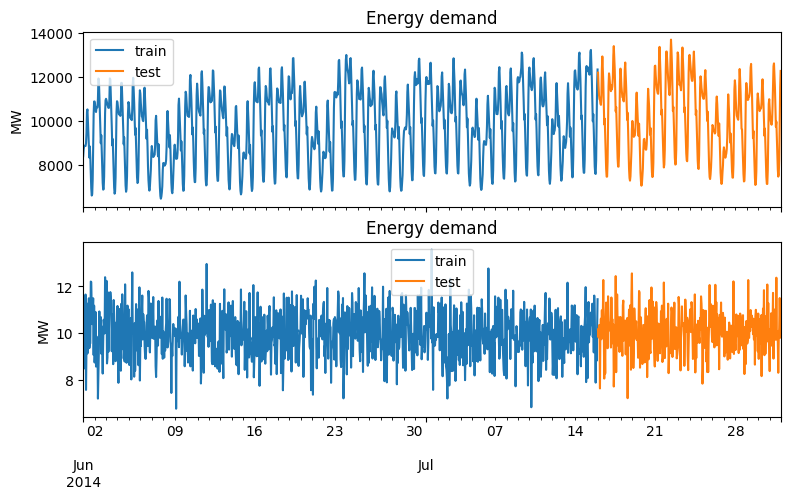

In [7]:
# Copy data and modify Temperature column as a normal distribution
# ==============================================================================
np.random.seed(123)
data_modified = data.copy()
data_modified['Temperature'] = np.random.normal(size=len(data_modified), loc=10, scale=1)

# Split data into train-val-test
# ==============================================================================
end_train = '2014-07-15 23:59:00'
data_train_modified = data_modified.loc[:end_train, :].copy()
data_test_modified  = data_modified.loc[end_train:, :].copy()

print(f"Train dates : {data_train_modified.index.min()} --- {data_train_modified.index.max()}  (n={len(data_train_modified)})")
print(f"Test dates  : {data_test_modified.index.min()} --- {data_test_modified.index.max()}  (n={len(data_test_modified)})")

# Plot Temperature
# ==============================================================================
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(9, 5), sharex=True)
data_train_modified['Demand'].plot(label='train', ax=axes[0])
data_test_modified['Demand'].plot(label='test', ax=axes[0])
axes[0].set_xlabel('')
axes[0].set_ylabel('MW')
axes[0].set_title('Energy demand')
axes[0].legend()

data_train_modified['Temperature'].plot(label='train', ax=axes[1])
data_test_modified['Temperature'].plot(label='test', ax=axes[1])
axes[1].set_xlabel('')
axes[1].set_ylabel('MW')
axes[1].set_title('Energy demand')
axes[1].legend()
axes[1].legend()
plt.show();

In [27]:
# ForecasterAutoregMultiSeries with linear models
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                 regressor          = LinearRegression(),
                 lags               = 24,
                 transformer_series = StandardScaler(),
                 transformer_exog   = None
             )

# Backtesting
# ==============================================================================
metric_demand, predictions_demand = backtesting_forecaster_multiseries(
                                          forecaster         = forecaster,
                                          series             = data_modified[['Demand', 'Temperature']],
                                          level              = 'Demand',
                                          initial_train_size = len(data_train_modified),
                                          fixed_train_size   = True,
                                          steps              = 24,
                                          metric             = 'mean_absolute_error',
                                          refit              = True,
                                          verbose            = False
                                    )

In [29]:
# Backtesting metrics
# ==============================================================================
print('Backtesting metrics using a multi-series forecaster')
print('===================================================')
print(f"Demand: {metric_demand:.2f}")

Backtesting metrics using a multi-series forecaster
Demand: 793.51


The error of the model has increased remarkably. This is due two the fact that the model is constrained to learn a unique global pattern for both series. Since the time series have very different internal dynamics (relation between their current and past values) the model is no capable of learning a pattern that suits both series.

## Multi series forecaster with non linear models

The same experiment is repeated, but this time using a non lineal model.

In [45]:
# ForecasterAutoreg with non linear models
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor        = RandomForestRegressor(random_state=123, n_jobs=-1),
                 lags             = 24,
                 transformer_y    = StandardScaler(),
                 transformer_exog = None
             )

metric_demand, predictions_demand = backtesting_forecaster(
                                        forecaster         = forecaster,
                                        y                  = data['Demand'],
                                        initial_train_size = len(data_train),
                                        fixed_train_size   = True,
                                        steps              = 24,
                                        metric             = 'mean_absolute_error',
                                        refit              = True,
                                        verbose            = False
                                )

metric_temperature, predictions_temperature = backtesting_forecaster(
                                                    forecaster         = forecaster,
                                                    y                  = data['Temperature'],
                                                    initial_train_size = len(data_train),
                                                    fixed_train_size   = True,
                                                    steps              = 24,
                                                    metric             = 'mean_absolute_error',
                                                    refit              = True,
                                                    verbose            = False
                                              )


In [46]:
# Backtesting metrics
# ==============================================================================
print(f"Backtest error Demand: {metric_demand:.2f}")
print(f"Backtest error Temperature: {metric_temperature:.2f}")

Backtest error Demand: 632.25
Backtest error Temperature: 2.18


In [42]:
# ForecasterAutoregMultiSeries with non linear models
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                 regressor          = RandomForestRegressor(random_state=123, n_jobs=-1),
                 lags               = 24,
                 transformer_series = StandardScaler(),
                 transformer_exog   = None
             )

# Backtesting
# ==============================================================================
metric_demand, predictions_demand = backtesting_forecaster_multiseries(
                                          forecaster         = forecaster,
                                          series             = data[['Demand', 'Temperature']],
                                          level              = 'Demand',
                                          initial_train_size = len(data_train),
                                          fixed_train_size   = True,
                                          steps              = 24,
                                          metric             = 'mean_absolute_error',
                                          refit              = True,
                                          verbose            = False
                                    )

metric_temperature, predictions_temperature = backtesting_forecaster_multiseries(
                                                 forecaster         = forecaster,
                                                 series             = data[['Demand', 'Temperature']],
                                                 level              = 'Temperature',
                                                 initial_train_size = len(data_train),
                                                 fixed_train_size   = True,
                                                 steps              = 24,
                                                 metric             = 'mean_absolute_error',
                                                 refit              = True,
                                                 verbose            = False
                                              )

In [44]:
# Backtesting metrics
# ==============================================================================
print(f"Backtest error Demand: {metric_demand:.2f}")
print(f"Backtest error Temperature: {metric_temperature:.2f}")

Backtest error Demand: 655.01
Backtest error Temperature: 2.02


Again, the performance of moth approaches are very similar. Let's see what happen if the resies do not share the same dinamycs.

In [7]:
# ForecasterAutoregMultiSeries with linear models
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                 regressor          = RandomForestRegressor(random_state=123, n_jobs=-1),
                 lags               = 24,
                 transformer_series = StandardScaler(),
                 transformer_exog   = None
             )

# Backtesting
# ==============================================================================
metric_demand, predictions_demand = backtesting_forecaster_multiseries(
                                          forecaster         = forecaster,
                                          series             = data_modified[['Demand', 'Temperature']],
                                          level              = 'Demand',
                                          initial_train_size = len(data_train_modified),
                                          fixed_train_size   = True,
                                          steps              = 24,
                                          metric             = 'mean_absolute_error',
                                          refit              = True,
                                          verbose            = False
                                    )

NameError: name 'data_modified' is not defined

In [48]:
# Backtesting metrics
# ==============================================================================
print(f"Backtest error Demand: {metric_demand:.2f}")

Backtest error Demand: 625.93


When using a non linear model, the forecasting performance is not harmed even though the time series do not follow the same dynamics. This is because the model is being able to identify that the series have more differences than similarities, and has flexibility enough to learn a different pattern for each one of the series.

One way to verify this hypothesis is to analyze how the threes of the model are created.

In [11]:
from sklearn.tree import export_text

forecaster.fit(series=data_modified[['Demand', 'Temperature']])


|--- lag_1 <= -0.01
|   |--- Demand <= 0.50
|   |   |--- truncated branch of depth 26
|   |--- Demand >  0.50
|   |   |--- truncated branch of depth 18
|--- lag_1 >  -0.01
|   |--- Temperature <= 0.50
|   |   |--- truncated branch of depth 17
|   |--- Temperature >  0.50
|   |   |--- truncated branch of depth 27



In [15]:
print(export_text(
        decision_tree = forecaster.regressor.estimators_[0],
        feature_names = feature_names,
        max_depth = 2
    )
)

|--- lag_1 <= -0.01
|   |--- Demand <= 0.50
|   |   |--- lag_3 <= 1.66
|   |   |   |--- truncated branch of depth 25
|   |   |--- lag_3 >  1.66
|   |   |   |--- truncated branch of depth 9
|   |--- Demand >  0.50
|   |   |--- lag_24 <= -0.72
|   |   |   |--- truncated branch of depth 17
|   |   |--- lag_24 >  -0.72
|   |   |   |--- truncated branch of depth 17
|--- lag_1 >  -0.01
|   |--- Temperature <= 0.50
|   |   |--- lag_1 <= 0.65
|   |   |   |--- truncated branch of depth 15
|   |   |--- lag_1 >  0.65
|   |   |   |--- truncated branch of depth 16
|   |--- Temperature >  0.50
|   |   |--- lag_22 <= 1.39
|   |   |   |--- truncated branch of depth 26
|   |   |--- lag_22 >  1.39
|   |   |   |--- truncated branch of depth 9



In [159]:
r = export_text(
        decision_tree = forecaster.regressor.estimators_[0],
        feature_names = feature_names
    )

re.split(r"|--- [a-zA-Z]", r)

['',
 '|',
 '',
 '',
 'a',
 'g',
 '_',
 '1',
 ' ',
 '<',
 '=',
 ' ',
 '-',
 '0',
 '.',
 '0',
 '1',
 '\n',
 '|',
 ' ',
 ' ',
 ' ',
 '|',
 '',
 '',
 'e',
 'm',
 'a',
 'n',
 'd',
 ' ',
 '<',
 '=',
 ' ',
 '0',
 '.',
 '5',
 '0',
 '\n',
 '|',
 ' ',
 ' ',
 ' ',
 '|',
 ' ',
 ' ',
 ' ',
 '|',
 '',
 '',
 'a',
 'g',
 '_',
 '3',
 ' ',
 '<',
 '=',
 ' ',
 '1',
 '.',
 '6',
 '6',
 '\n',
 '|',
 ' ',
 ' ',
 ' ',
 '|',
 ' ',
 ' ',
 ' ',
 '|',
 ' ',
 ' ',
 ' ',
 '|',
 '',
 '',
 'a',
 'g',
 '_',
 '1',
 '2',
 ' ',
 '<',
 '=',
 ' ',
 '0',
 '.',
 '8',
 '1',
 '\n',
 '|',
 ' ',
 ' ',
 ' ',
 '|',
 ' ',
 ' ',
 ' ',
 '|',
 ' ',
 ' ',
 ' ',
 '|',
 ' ',
 ' ',
 ' ',
 '|',
 '',
 '',
 'a',
 'g',
 '_',
 '4',
 ' ',
 '<',
 '=',
 ' ',
 '-',
 '2',
 '.',
 '4',
 '5',
 '\n',
 '|',
 ' ',
 ' ',
 ' ',
 '|',
 ' ',
 ' ',
 ' ',
 '|',
 ' ',
 ' ',
 ' ',
 '|',
 ' ',
 ' ',
 ' ',
 '|',
 ' ',
 ' ',
 ' ',
 '|',
 '',
 '',
 'a',
 'g',
 '_',
 '2',
 '4',
 ' ',
 '<',
 '=',
 ' ',
 '0',
 '.',
 '0',
 '5',
 '\n',
 '|',
 ' ',
 ' ',
 ' ',
 '|',
 ' ',

In [9]:
top_3_nodes = []
feature_names = list(forecaster.create_train_X_y(data_modified[['Demand', 'Temperature']])[0].columns)

In [154]:
top_3_nodes = []
feature_names = list(forecaster.create_train_X_y(data_modified[['Demand', 'Temperature']])[0].columns)

for tree in forecaster.regressor.estimators_:
    r = export_text(
        decision_tree = tree,
        feature_names = feature_names
    )
    r = [re.sub('\|--- ', '', node) for node in r.split('|   |')]
    r = [re.sub('--- ', '', node) for node in r]
    r = [re.sub('  +', '', node) for node in r]
    r = [node.split(' ')[0]  for node in r]
    r = [word for word in r if word in feature_names]
    # remove duplicates
    #r = list(dict.fromkeys(r))
    top_3_nodes.append(r)


In [155]:
top_3_nodes[0]

['lag_1',
 'Demand',
 'lag_3',
 'lag_12',
 'lag_4',
 'lag_24',
 'lag_24',
 'lag_21',
 'lag_21',
 'lag_4',
 'lag_9',
 'lag_11',
 'lag_10',
 'lag_9',
 'lag_9',
 'lag_4',
 'lag_4',
 'lag_10',
 'lag_19',
 'lag_20',
 'lag_15',
 'lag_15',
 'lag_20',
 'lag_18',
 'lag_18',
 'lag_19',
 'lag_18',
 'lag_18',
 'lag_18',
 'lag_18',
 'lag_11',
 'lag_9',
 'lag_14',
 'lag_14',
 'lag_7',
 'lag_12',
 'lag_12',
 'lag_7',
 'lag_17',
 'lag_17',
 'lag_9',
 'lag_17',
 'lag_7',
 'lag_7',
 'lag_17',
 'lag_12',
 'lag_9',
 'lag_9',
 'lag_12',
 'lag_11',
 'lag_11',
 'lag_9',
 'lag_19',
 'lag_21',
 'lag_18',
 'lag_8',
 'lag_4',
 'lag_4',
 'lag_8',
 'lag_8',
 'lag_8',
 'lag_18',
 'lag_15',
 'lag_7',
 'lag_7',
 'lag_15',
 'lag_21',
 'lag_21',
 'lag_21',
 'lag_23',
 'lag_12',
 'lag_9',
 'lag_9',
 'lag_12',
 'lag_16',
 'lag_16',
 'lag_23',
 'lag_16',
 'lag_4',
 'lag_4',
 'lag_16',
 'lag_19',
 'lag_19',
 'lag_19',
 'lag_4',
 'lag_9',
 'lag_1',
 'lag_17',
 'lag_17',
 'lag_1',
 'lag_9',
 'lag_20',
 'lag_20',
 'lag_8',
 '

In [118]:
for feature in feature_names:
    

top_3_nodes

IndentationError: expected an indented block (3885159632.py, line 4)

In [119]:
top_3_nodes = pd.DataFrame(
                data = top_3_nodes,
                columns= ['first_node', 'second_node', 'third_node']
              )
top_3_nodes


,first_node,second_node,third_node
0,lag_1,Demand,lag_3
1,lag_1,Temperature,lag_24
2,lag_1,lag_24,Temperature
3,lag_1,Temperature,lag_24
4,lag_1,Demand,lag_19
...,...,...,...
95,lag_1,Demand,lag_12
96,lag_1,Temperature,lag_24
97,lag_1,Temperature,lag_24
98,lag_1,Temperature,lag_24


In [116]:
for col in top_3_nodes.columns:
    print(col)
    print("---")
    print(top_3_nodes[col].value_counts())

first_node
---
lag_1    100
Name: first_node, dtype: int64
second_node
---
Demand         35
Temperature    35
lag_24         20
lag_23         10
Name: second_node, dtype: int64
third_node
---
lag_24         35
Temperature    19
Demand         11
lag_18          9
lag_17          7
lag_1           4
lag_12          4
lag_20          2
lag_4           2
lag_14          2
lag_3           1
lag_19          1
lag_8           1
lag_9           1
lag_6           1
Name: third_node, dtype: int64


In [85]:
import re
r = [re.sub('\|--- ', '', node) for node in r.split('|   |')[:3]]
r = [re.sub('--- ', '', node) for node in r]
r = [re.sub('  +', '', node) for node in r]
r = [node.split(' ')[0]  for node in r]
print(r)


['lag_1', 'Demand', 'lag_19']


In [79]:
r = [node.split(' ')[0]  for node in r]

['lag_1',
 'Demand',
 'lag_19',
 '',
 'truncated',
 'lag_19',
 '',
 'truncated',
 'Demand',
 'lag_24',
 '',
 'truncated',
 'lag_24',
 '',
 'truncated',
 'Demand',
 'lag_3',
 '',
 'truncated',
 'lag_3',
 '',
 'truncated',
 'Demand',
 'lag_1',
 '',
 'truncated',
 'lag_1',
 '',
 'truncated']

In [40]:
[node.split(' ')[0]  for node in r]

['|',
 '-',
 '-',
 '-',
 '',
 'l',
 'a',
 'g',
 '_',
 '1',
 '',
 '<',
 '=',
 '',
 '-',
 '0',
 '.',
 '0',
 '1',
 '\n',
 '|',
 '',
 '',
 '',
 '|',
 '-',
 '-',
 '-',
 '',
 'D',
 'e',
 'm',
 'a',
 'n',
 'd',
 '',
 '<',
 '=',
 '',
 '0',
 '.',
 '5',
 '0',
 '\n',
 '|',
 '',
 '',
 '',
 '|',
 '',
 '',
 '',
 '|',
 '-',
 '-',
 '-',
 '',
 'l',
 'a',
 'g',
 '_',
 '1',
 '9',
 '',
 '<',
 '=',
 '',
 '1',
 '.',
 '1',
 '0',
 '\n',
 '|',
 '',
 '',
 '',
 '|',
 '',
 '',
 '',
 '|',
 '',
 '',
 '',
 '|',
 '-',
 '-',
 '-',
 '',
 't',
 'r',
 'u',
 'n',
 'c',
 'a',
 't',
 'e',
 'd',
 '',
 'b',
 'r',
 'a',
 'n',
 'c',
 'h',
 '',
 'o',
 'f',
 '',
 'd',
 'e',
 'p',
 't',
 'h',
 '',
 '2',
 '6',
 '\n',
 '|',
 '',
 '',
 '',
 '|',
 '',
 '',
 '',
 '|',
 '-',
 '-',
 '-',
 '',
 'l',
 'a',
 'g',
 '_',
 '1',
 '9',
 '',
 '>',
 '',
 '',
 '1',
 '.',
 '1',
 '0',
 '\n',
 '|',
 '',
 '',
 '',
 '|',
 '',
 '',
 '',
 '|',
 '',
 '',
 '',
 '|',
 '-',
 '-',
 '-',
 '',
 't',
 'r',
 'u',
 'n',
 'c',
 'a',
 't',
 'e',
 'd',
 '',
 'b',
 'r'

In [16]:
list(forecaster.create_train_X_y(data_modified[['Demand', 'Temperature']])[0].columns)

['lag_1',
 'lag_2',
 'lag_3',
 'lag_4',
 'lag_5',
 'lag_6',
 'lag_7',
 'lag_8',
 'lag_9',
 'lag_10',
 'lag_11',
 'lag_12',
 'lag_13',
 'lag_14',
 'lag_15',
 'lag_16',
 'lag_17',
 'lag_18',
 'lag_19',
 'lag_20',
 'lag_21',
 'lag_22',
 'lag_23',
 'lag_24',
 'Demand',
 'Temperature']

In [18]:
%%html
<style>
.jupyter-wrapper .jp-CodeCell .jp-Cell-inputWrapper .jp-InputPrompt {display: none;}
</style>